In [1]:
# import statements

from torch import nn
import torch
import gym
from collections import deque
import itertools
import numpy as np
import random
import pdb
from matplotlib import pyplot as plt 
import pandas as pd

In [2]:
# hyperparameters

GAMMA = 0.99
NUM_NODES = 24
BATCH_SIZE = 32
BUFFER_SIZE = 50000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY = 10000
TARGET_UPDATE_FREQ = 1000
LEARNING_RATE = 5e-4
MAX_STEPS = 60000

# Regularization Coefficient
REGULARIZATION_COEFFICIENT = 0.1

### Custom Loss Functions

In [3]:
phi_matrix = []
observations_t = None
new_observations_t = None
online_net = None

In [4]:
# default loss function - mean squared error

def default_loss_mse(y_true, y_pred):
    
    loss = torch.mean(torch.square(y_true-y_pred))
    
    return loss

In [5]:
# custom loss function - implements explicit DR3 regularizer

# add dot product between each state action and subsequent one’s feature vector to loss
def dr3(y_true, y_pred):
    
    global observations_t, new_observations_t, online_net
    
    loss = torch.mean(torch.square(y_true-y_pred))
        
    curr_states = online_net.get_phi(observations_t)
    next_states = online_net.get_phi(new_observations_t)

    # pdb.set_trace()

    loss += REGULARIZATION_COEFFICIENT * torch.sum(torch.sum(curr_states * next_states, axis=1)) / BATCH_SIZE
    
    return loss

In [6]:
# custom loss function - random dot product from phi matrix

# randomly sample two vectors from the phi matrix and add dot product of those vectors to loss
def random_dot(y_true, y_pred):

    global phi_matrix
    
    loss = torch.mean(torch.square(y_true-y_pred))
    
    # Explicit Regularization
    if ((phi_matrix is not None) and (len(phi_matrix) > 1)):
        
        v1 = phi_matrix[random.randrange(len(phi_matrix))]
        v2 = phi_matrix[random.randrange(len(phi_matrix))]
        
        # pdb.set_trace()
        
        loss += REGULARIZATION_COEFFICIENT * torch.dot(torch.tensor(v1), torch.tensor(v2))
        
    return loss

In [7]:
# custom loss function - implements regulizer based on min/max singular values in phi matrix

# add difference between max entry in phi matrix ** 2 and min entry in phi matrix ** 2 to loss
def phi_penalty(y_true, y_pred):
    
    global phi_matrix
    
    loss = torch.mean(torch.square(y_true-y_pred))
    
    # Explicit Regularization
    if ((phi_matrix is not None) and (len(phi_matrix) > 0)):
        
        minimum = min([min(value) for value in phi_matrix])
        maximum = max([max(value) for value in phi_matrix])
        
        # pdb.set_trace()
        
        loss += REGULARIZATION_COEFFICIENT * torch.sub(maximum**2, minimum**2)
            
    return loss

### Network Class

In [8]:
# create network class

class Network(nn.Module):
    
    def __init__(self, env):
        super().__init__()        
        in_features = int(np.prod(env.observation_space.shape))     
        # Neural Network
        self.layer1 = nn.Linear(in_features, NUM_NODES)
        self.layer2 = nn.ReLU()
        self.layer3 = nn.ReLU()
        self.layer4 = nn.Linear(NUM_NODES, env.action_space.n)
    
    def forward(self, x):
        return self.layer4(self.layer3(self.layer2(self.layer1(x))))
    
    def act(self, obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))
        
        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()
        
        return action
    
    def get_phi(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

### Run

In [9]:
def run(random_seed, loss_function):
    
    global observations_t, new_observations_t, online_net

    # create environment

    env = gym.make('CartPole-v0')
    
    # set random seeds 
    
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    replay_buffer = deque(maxlen=BUFFER_SIZE)
    reward_buffer = deque([0.0], maxlen=100)

    all_ranks = []
    all_rewards = []

    episode_reward = 0.0

    online_net = Network(env)
    target_net = Network(env)

    target_net.load_state_dict(online_net.state_dict())

    optimizer = torch.optim.Adam(online_net.parameters(), lr=LEARNING_RATE)

    obs = env.reset()
    for _ in range(MIN_REPLAY_SIZE):

        action = env.action_space.sample()
        new_obs, reward, done, info = env.step(action)
        transition = (obs, action, reward, done, new_obs)
        replay_buffer.append(transition)
        obs = new_obs

        if done:
            obs = env.reset() 

    # training

    obs = env.reset()

    for step in range(1, MAX_STEPS+1):

        epsilon = np.interp(step, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])

        rng = random.random()
        if rng <= epsilon:
            action = env.action_space.sample()
        else:
            action = online_net.act(obs)

        new_obs, reward, done, _ = env.step(action)
        transition = (obs, action, reward, done, new_obs)
        replay_buffer.append(transition)
        obs = new_obs

        episode_reward += reward

        if done:
            obs = env.reset()
            reward_buffer.append(episode_reward)
            all_rewards.append(episode_reward)
            episode_reward = 0.0

        # Start Gradient Step   
        transitions = random.sample(replay_buffer, BATCH_SIZE)

        observations = np.asarray([t[0] for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rewards = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_observations = np.asarray([t[4] for t in transitions])

        observations_t = torch.as_tensor(observations, dtype=torch.float32)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
        new_observations_t = torch.as_tensor(new_observations, dtype=torch.float32)

        # Compute Targets
        target_q_values = target_net(new_observations_t)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

        targets = rewards_t + GAMMA * (1 - dones_t) * max_target_q_values

        # Compute Loss
        q_values = online_net(observations_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)
        loss = loss_function(action_q_values, targets)

        # Gradient Descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute Phi Matrix
        phi_matrix = []
        phi_matrix = online_net.get_phi(observations_t)
        phi_matrix = phi_matrix.cpu().detach().numpy()
        rank = np.linalg.matrix_rank(phi_matrix)
        all_ranks.append(rank)

        # Update Target Network
        if step % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(online_net.state_dict())
    
    return all_ranks, all_rewards

### Run Tests

In [10]:
def get_CI(data, confidence = 0.95):
    
    if (np.array(data) == None).all():
        return {}
    
    if confidence == 0.95:
        z = 1.96
    elif confidence == 0.99:
        z = 2.576
    
    stats = {}
    n = len(data)
    mean = np.mean(data)
    std = np.std(data)
    err = z * (std / np.sqrt(n))
    lower = mean - z * (std / np.sqrt(n))
    upper = mean + z * (std / np.sqrt(n))
    
    stats = {
        'mean': mean,
        'std': std,
        'lower': lower,
        'upper': upper,
        'err': err,
        'max': np.max(data),
        'min': np.min(data)
    }
    
    return stats 

In [11]:
loss_functions = [default_loss_mse, dr3, random_dot, phi_penalty]
random_seeds = [0, 1, 2, 3, 4, 5, 7, 10, 26, 2002]

all_ranks = {}
all_rewards = {}

column_names = [i for i in range(1, MAX_STEPS+1)]

for loss_function in loss_functions:
    ranks_df = pd.DataFrame(columns = column_names)
    rewards_df = pd.DataFrame(columns = column_names)
    for random_seed in random_seeds:
        ranks, rewards = run(random_seed, loss_function)
        ranks_df = ranks_df.append(pd.DataFrame([ranks], columns=column_names), ignore_index=True)
        rewards += [None for i in range(MAX_STEPS-len(rewards))]
        rewards_df = rewards_df.append(pd.DataFrame([rewards], columns=column_names), ignore_index=True)
        print(loss_function.__name__, random_seed, ":", np.mean(ranks[:10]) - np.mean(ranks[-10:]))
    all_ranks[loss_function.__name__] = ranks_df
    all_rewards[loss_function.__name__] = rewards_df.dropna(axis='columns')
    print()

default_loss_mse 0 : 8.299999999999999
default_loss_mse 1 : 7.699999999999999
default_loss_mse 2 : 9.700000000000001
default_loss_mse 3 : 9.100000000000001
default_loss_mse 4 : 12.3
default_loss_mse 5 : 7.9
default_loss_mse 7 : 7.1
default_loss_mse 10 : 13.9
default_loss_mse 26 : 6.399999999999999
default_loss_mse 2002 : 8.3

dr3 0 : 13.3
dr3 1 : 9.799999999999999
dr3 2 : 8.399999999999999
dr3 3 : 7.899999999999999
dr3 4 : 13.2
dr3 5 : 4.299999999999997
dr3 7 : 6.1
dr3 10 : 15.200000000000001
dr3 26 : 7.499999999999998
dr3 2002 : 6.1

random_dot 0 : 8.600000000000001
random_dot 1 : 8.000000000000002
random_dot 2 : 10.6
random_dot 3 : 5.299999999999999
random_dot 4 : 12.399999999999999
random_dot 5 : 8.400000000000002
random_dot 7 : 7.399999999999999
random_dot 10 : 14.000000000000002
random_dot 26 : 6.100000000000001
random_dot 2002 : 11.4

phi_penalty 0 : 9.799999999999999
phi_penalty 1 : 9.2
phi_penalty 2 : 10.799999999999999
phi_penalty 3 : 4.300000000000001
phi_penalty 4 : 13.5
phi

DEFAULT_LOSS_MSE


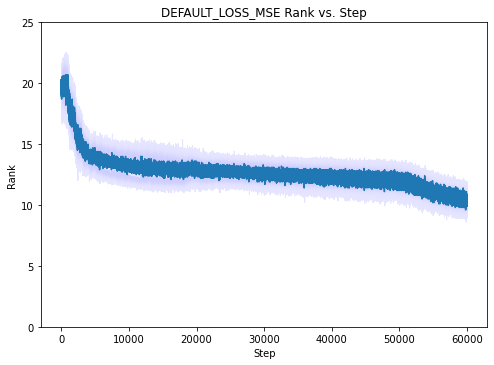

DR3


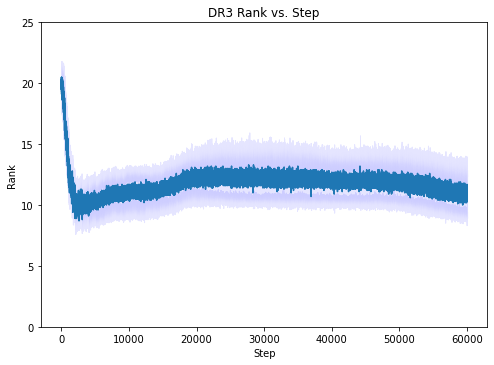

RANDOM_DOT


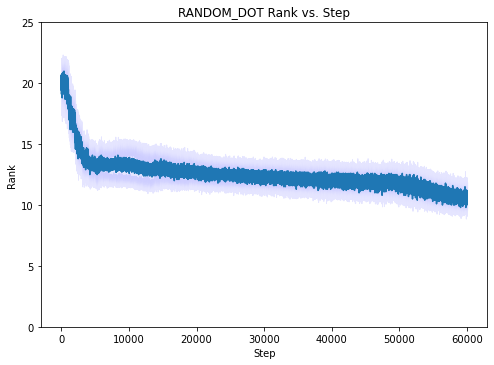

PHI_PENALTY


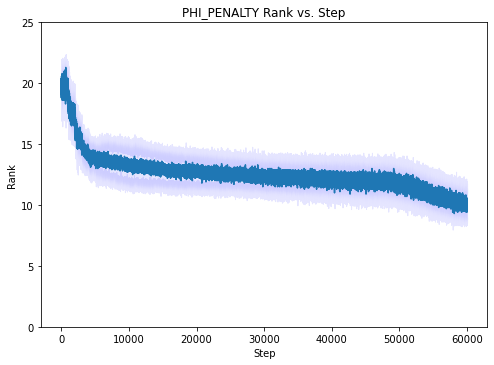

In [12]:
for key in all_ranks:
    
    df = all_ranks[key]
    print(key.upper())
    
    indexes = [i for i in range(1, MAX_STEPS+1)]
    means = [get_CI(df[col])['mean'] for col in df]
    upper_bounds = [get_CI(df[col])['upper'] for col in df]
    lower_bounds = [get_CI(df[col])['lower'] for col in df]
    
    fig, ax = plt.subplots(figsize=(8,5.6))
    ax.axis(ymin=0,ymax=25)
    ax.set_title(key.upper() + ' Rank vs. Step')
    ax.set_xlabel('Step')
    ax.set_ylabel('Rank')
    ax.plot(indexes,means)
    ax.fill_between(indexes, lower_bounds, upper_bounds, color='b', alpha=.1)
    plt.show()

DEFAULT_LOSS_MSE


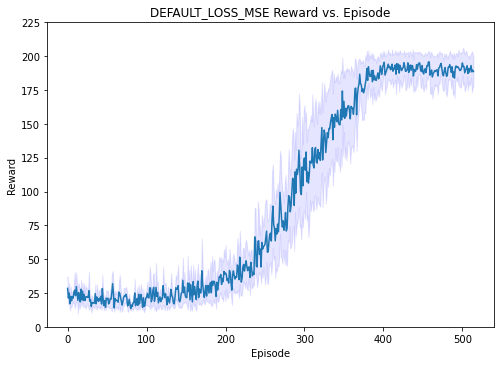

DR3


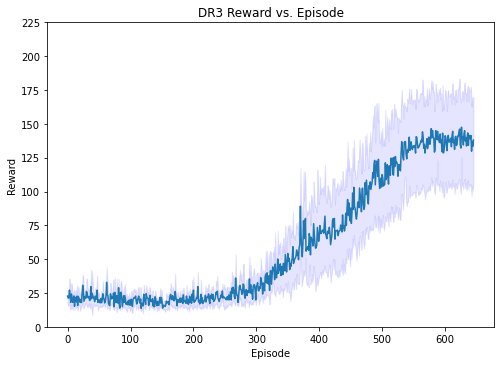

RANDOM_DOT


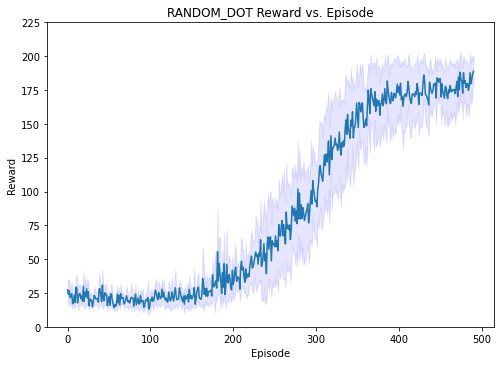

PHI_PENALTY


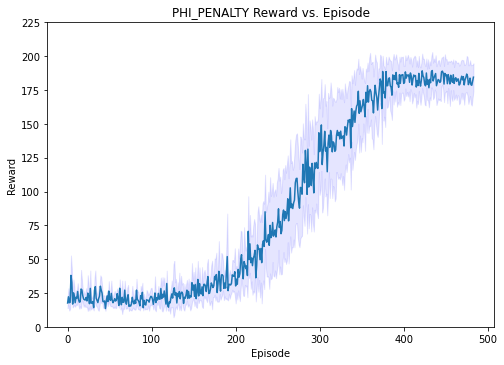

In [13]:
for key in all_rewards:
    
    df = all_rewards[key]
    print(key.upper())
    
    indexes = [i for i in range(len(df.columns))]
    means = [get_CI(df[col])['mean'] for col in df]
    upper_bounds = [get_CI(df[col])['upper'] for col in df]
    lower_bounds = [get_CI(df[col])['lower'] for col in df]
    
    fig, ax = plt.subplots(figsize=(8,5.6))
    ax.axis(ymin=0,ymax=225)
    ax.set_title(key.upper() + ' Reward vs. Episode')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.plot(indexes,means)
    ax.fill_between(indexes, lower_bounds, upper_bounds, color='b', alpha=.1)
    plt.show()